In [0]:
%tensorflow_version 2.x
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
import random

In [2]:
x, y = load_digits(return_X_y=True)
x.shape, y.shape, set(y)

((1797, 64), (1797,), {0, 1, 2, 3, 4, 5, 6, 7, 8, 9})

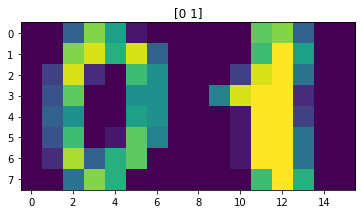

In [0]:
xx0 = np.concatenate((x[0].reshape((8,8)), x[1].reshape((8,8))), axis=1)
xx1 = np.concatenate((x[2].reshape((8,8)), x[3].reshape((8,8))), axis=1)
yy0 = y[:2]
yy1 = y[2:4]
# plt.title(str(yy0))
# plt.imshow(xx0)

In [0]:
x_train = np.stack((xx0, xx1), 0)
y_train = np.stack((yy0, yy1), 0)
x_train.shape, y_train.shape

((2, 8, 16), (2, 2))

In [0]:
#전문가 모델
class MyModel(keras.Model):
  def __init__(self):
    super(MyModel, self).__init__()#상속한 클래스의 생성자 호출 
    self.opt = tf.optimizers.SGD(learning_rate=0.01)#Stochatic Gradient Descent 확률적 경사 하강
    self.conv0 = keras.layers.Conv2D(16, [3,3], padding='same', activation=keras.activations.relu)
    self.conv1 = keras.layers.Conv2D(32, [3,3], padding='same', activation=keras.activations.relu)
    self.pool0 = keras.layers.MaxPool2D([2,2], padding='same')
    self.pool1 = keras.layers.MaxPool2D([2,2], padding='same')
    self.flatten = keras.layers.Flatten()
    self.dense = keras.layers.Dense(units=10*2)
  
  def call(self, x):
    #x (1797, 64)
    x_4d = tf.reshape(x, [-1,8,16,1]) 
    x_4d = tf.cast(x_4d, tf.float32)
    net = self.conv0(x_4d)
    net = self.pool0(net)
    net = self.conv1(net)
    net = self.pool1(net)
    net = self.flatten(net)    
    h = self.dense(net)
    h = tf.reshape(h, [-1,2,10]) # 2:두자리수, 10:10개의 클래스
    h = tf.nn.softmax(h, axis=2) 
    return h

  def get_loss(self, y, h):
    #학습할때 nan이 발생하는 경우 값을 clip(자르다) (최소값, 최대값) 
    h = tf.clip_by_value(h, 1e-8, 1 - 1e-8) # h 가 0이나 1이 되지 않도록 하는 안전장치 
    cross_entropy = - (y * tf.math.log(h) + (1 - y) * tf.math.log(1 - h)) 
    loss = tf.reduce_mean(cross_entropy)
    return loss

  def get_accuracy(self, y, h):    
    predict = tf.argmax(h, -1)
    self.acc = tf.reduce_mean(tf.cast(tf.equal(y, predict), tf.float32)) # True > 1, False > 0 로 cast

  def fit(self, x, y, epoch=1):
    # x : (m, 8, 16), y: (m, 2)    
    y_hot = tf.one_hot(y, depth=10, axis=-1) # (m, 2, 10)
    for i in range(epoch):
      with tf.GradientTape() as tape: #경사 기록 장치
        h = self.call(x)
        loss = self.get_loss(y_hot, h)        
      grads = tape.gradient(loss, self.trainable_variables) #경사 계산
      self.opt.apply_gradients(zip(grads, self.trainable_variables)) # 가중치에서 경사를 빼기
      self.get_accuracy(y, h)
      if i%10==0:
        print('%d/%d loss:%.3f acc:%.3f'%(i, epoch, loss, self.acc))
model = MyModel()

In [0]:
model.fit(x_train, y_train, 100)

0/100 loss:0.606 acc:0.000
10/100 loss:0.157 acc:0.500
20/100 loss:0.033 acc:1.000
30/100 loss:0.017 acc:1.000
40/100 loss:0.012 acc:1.000
50/100 loss:0.009 acc:1.000
60/100 loss:0.007 acc:1.000
70/100 loss:0.006 acc:1.000
80/100 loss:0.005 acc:1.000
90/100 loss:0.004 acc:1.000


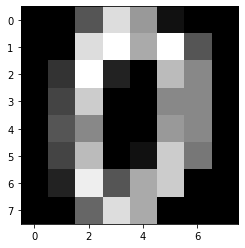

In [0]:
x0 = x[0].astype(np.uint8).reshape((8,8))
plt.imshow(x0, cmap='gray')

실습해보기<br>
훈련:테스트 = 50:50

In [0]:
%tensorflow_version 2.x
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits


In [23]:
x, y = load_digits(return_X_y=True)
x.shape, y.shape, set(y)

((1797, 64), (1797,), {0, 1, 2, 3, 4, 5, 6, 7, 8, 9})

In [24]:
x = np.array([tf.reshape(image, [8,8]) for image in x])
x.shape

(1797, 8, 8)

In [25]:
idx = len(x)//2
x_train = x[:idx]
y_train = y[:idx]
x_test = x[idx:-1]
y_test = y[idx:-1]
x_train.shape, y_train.shape, x_test.shape, y_test.shape, idx

((898, 8, 8), (898,), (898, 8, 8), (898,), 898)

In [0]:
train_image = []
test_image = []
train_label = []
test_label = []

for _ in range(20000):
  rnd1 = random.randrange(0, idx-1)
  rnd2 = random.randrange(0, idx-1)
  train_image.append(tf.reshape(np.stack((x_train[rnd1], x_train[rnd2]), axis=1), [8, -1]))
  train_label.append([y_train[rnd1], y_train[rnd2]])

for i in range(idx//2):
  test_image.append(tf.reshape(np.stack((x_test[i*2], x_test[i*2+1]), axis=1), [8, -1]))
  test_label.append(y_test[i*2:i*2+2])

데이터 확인

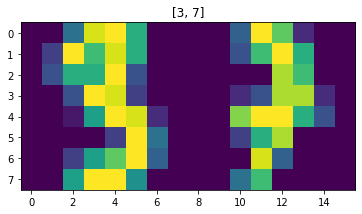

In [27]:
plt.title(train_label[104])
plt.imshow(train_image[104])

/usr/local/lib/python3.6/dist-packages/matplotlib/text.py:1150: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


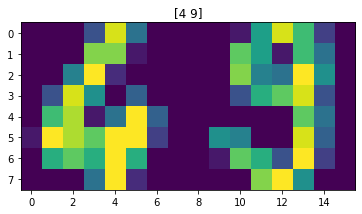

In [28]:
plt.title(test_label[1])
plt.imshow(test_image[1])

In [0]:
train_image = np.array(train_image)
test_image = np.array(test_image)
train_label = np.array(train_label)
test_label = np.array(test_label)

In [0]:
train_image.shape, test_image.shape, train_label.shape, test_label.shape

((10000, 8, 16), (449, 8, 16), (10000, 2), (449, 2))

In [0]:
#전문가 모델
class DigitModel(keras.Model):
  def __init__(self):
    super(DigitModel, self).__init__()#상속한 클래스의 생성자 호출 
    # self.lr_schedule = keras.optimizers.schedules.InverseTimeDecay(0.001,
    #                                                                decay_steps=1000,
    #                                                                decay_rate=1,
    #                                                                staircase=False)
    self.opt = tf.optimizers.Adam(keras.optimizers.schedules.InverseTimeDecay(0.001,
                                                                    decay_steps=1000,
                                                                    decay_rate=1,
                                                                    staircase=False)) #Stochatic Gradient Descent 확률적 경사 하강
    self.conv0 = keras.layers.Conv2D(128, [3,3], padding='same', activation=keras.activations.relu)
    self.conv1 = keras.layers.Conv2D(64, [3,3], padding='same', activation=keras.activations.relu)
    self.conv2 = keras.layers.Conv2D(32, [3,3], padding='same', activation=keras.activations.relu)
    self.conv3 = keras.layers.Conv2D(32, [3,3], padding='same', activation=keras.activations.relu)
    self.pool0 = keras.layers.MaxPool2D([2,2], padding='same')
    self.pool1 = keras.layers.MaxPool2D([2,2], padding='same')
    self.pool2 = keras.layers.MaxPool2D([2,2], padding='same')
    self.pool3 = keras.layers.MaxPool2D([2,2], padding='same')
    self.flatten = keras.layers.Flatten()
    self.l2 = keras.regularizers.l2(l=0.01)
    self.dense0 = keras.layers.Dense(units=128, activation=keras.activations.relu)
    self.drop = keras.layers.Dropout(0.5)
    self.dense1 = keras.layers.Dense(units=10*2)
  
  def call(self, x):
    #x (1797, 64)
    x_4d = tf.reshape(x, [-1,8,16,1]) 
    x_4d = tf.cast(x_4d, tf.float32)
    net = self.conv0(x_4d)
    net = self.pool0(net)
    net = self.conv1(net)
    net = self.pool1(net)
    net = self.flatten(net)
    net = self.dense0(net)
    net = self.drop(net) 
    # net = self.l2(net)   
    h = self.dense1(net)
    h = tf.reshape(h, [-1,2,10]) # 2:두자리수, 10:10개의 클래스
    h = tf.nn.softmax(h, axis=2) 
    return h

  def get_loss(self, y, h):
    #학습할때 nan이 발생하는 경우 값을 clip(자르다) (최소값, 최대값) 
    h = tf.clip_by_value(h, 1e-8, 1 - 1e-8) # h 가 0이나 1이 되지 않도록 하는 안전장치 
    cross_entropy = - (y * tf.math.log(h) + (1 - y) * tf.math.log(1 - h)) 
    loss = tf.reduce_mean(cross_entropy)
    return loss

  def get_accuracy(self, y, h):    
    predict = tf.argmax(h, -1)
    is_equal = tf.equal(y, predict)
    self.acc = tf.reduce_mean(tf.cast(tf.equal(y, predict), tf.float32)) # True > 1, False > 0 로 cast
    self.acc_all = tf.reduce_mean(tf.cast(tf.reduce_all(is_equal, axis=1), tf.float32))


  def fit(self, x, y, epoch=1):
    # x : (m, 8, 16), y: (m, 2)    
    y_hot = tf.one_hot(y, depth=10, axis=-1) # (m, 2, 10)
    for i in range(epoch):
      with tf.GradientTape() as tape: #경사 기록 장치
        h = self.call(x)
        loss = self.get_loss(y_hot, h)        
      grads = tape.gradient(loss, self.trainable_variables) #경사 계산
      self.opt.apply_gradients(zip(grads, self.trainable_variables)) # 가중치에서 경사를 빼기
      self.get_accuracy(y, h)
      if i%10==0:
        print('%d/%d loss:%.3f acc:%.3f'%(i, epoch, loss, self.acc))
model = DigitModel()

In [0]:
model.fit(train_image, train_label, 400)

In [0]:
# 테스트셋의 성능
h = model(test_image)
model.get_accuracy(test_label, h)
model.acc, model.acc_all

In [0]:
class MyModel(keras.Model):
  def __init__(self):
    super(MyModel, self).__init__() #상속한 클래스의 생성자 호출 
    self.opt = tf.optimizers.Adam(learning_rate=0.001) 
    self.conv0 = keras.layers.Conv2D(128, [3,3], padding='same', activation=keras.activations.relu, input_shape=(8, 16))
    self.conv1 = keras.layers.Conv2D(64, [3,3], padding='same', activation=keras.activations.relu)
    self.conv2 = keras.layers.Conv2D(32, [3,3], padding='same', activation=keras.activations.relu)
    self.conv3 = keras.layers.Conv2D(32, [3,3], padding='same', activation=keras.activations.relu)
    self.pool0 = keras.layers.MaxPool2D([2,2], padding='same')
    self.pool1 = keras.layers.MaxPool2D([2,2], padding='same')
    self.pool2 = keras.layers.MaxPool2D([2,2], padding='same')
    self.pool3 = keras.layers.MaxPool2D([2,2], padding='same')
    self.flatten = keras.layers.Flatten()
    self.l2 = keras.regularizers.l2()
    self.dense0 = keras.layers.Dense(units=128, activation=keras.activations.relu)
    self.drop = keras.layers.Dropout(0.4)
    self.dense1 = keras.layers.Dense(units=2*10)
    self.bn = keras.layers.BatchNormalization()
  
  def call(self, x):
    # x (none, 8, 16)
    x_4d = tf.reshape(x, [-1,8,16,1]) 
    x_4d = tf.cast(x_4d, tf.float32)
    net = self.conv0(x_4d)
    net = self.pool0(net)
    net = self.conv1(net)
    net = self.pool1(net)
    net = self.conv2(net)
    net = self.pool2(net)
    net = self.flatten(net)
    net = self.dense0(net)
    net = self.bn(net)
    net = self.drop(net)   
    h = self.dense1(net)
    h = tf.reshape(h, [-1,2,10]) # 2:두자리수, 10:10개의 클래스 (none, 2, 10)
    h = tf.nn.softmax(h, axis=2) # (none, 2) 
    return h

model = MyModel()  

In [0]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

@tf.function
def train_step(images, labels):
  with tf.GradientTape() as tape:
    predictions = model(images)
    loss = loss_object(labels, predictions)
  gradients = tape.gradient(loss, model.trainable_variables) # loss에 대한 파라미터들의 도함수
  # list of (gradients, variables) pairs
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))
  train_loss(loss)
  train_accuracy(labels, predictions)

@tf.function
def test_step(images, labels):
  predictions = model(images)
  t_loss = loss_object(labels, predictions)
  
  test_loss(t_loss)
  test_accuracy(labels, predictions)

In [0]:
train_ds = tf.data.Dataset.from_tensor_slices((train_image, train_label)).shuffle(10000).batch(64)
test_ds = tf.data.Dataset.from_tensor_slices((test_image, test_label)).shuffle(10000).batch(64)

In [58]:
EPOCHS = 1000

for epoch in range(EPOCHS):

  for images, labels in train_ds:
    train_step(images, labels)

  for test_images, test_labels in test_ds:
    test_step(test_images, test_labels)

  template = '에포크: {}, 손실: {}, 정확도: {}, 테스트 손실: {}, 테스트 정확도: {}'

  if epoch % 10 == 0:
    print (template.format(epoch+1,
                         train_loss.result(),
                         train_accuracy.result()*100,
                         test_loss.result(),
                         test_accuracy.result()*100))


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

에포크: 1, 손실: 2.2599027156829834, 정확도: 15.930000305175781, 테스트 손실: 2.1799135208129883, 테스트 정확도: 19.265033721923828
에포크: 11, 손실: 1.0210870504379272, 정확도: 72.29522705078125, 테스트 손실: 1.0404301881790161, 테스트 정확도: 70.46973419189453
에포크: 21, 손실: 0.5805092453956604, 정확도: 84.5759506225586, 테스트 손실: 0.6683867573738098, 테스트 정확도: 80.50694274902344
에포크: 31, 손실: 0.405892550945282, 정확도: 89.36072540283203, 테스트 손실: 0.5282995700836182, 테스트 정확도: 84.58940887451172
에포크: 41, 손실: 0.3121751844882965, 정확도: 91.90377807617188, 테스트 